# **Accelerating Geopolitical Analysis: A Guide to Graph Machine Learning with Dask and cuGraph**

In this tutorial, we'll analyze the structure of international alliances during the Cold War using the [**RAPIDS** ecosystem](https://rapids.ai/ecosystem/): **Dask** for scalable data processing and **cuGraph** for massively parallel, GPU-accelerated graph analytics.

The goal is to transform the complex web of historical treaties from the [Correlates of War (COW) Formal Alliance dataset](https://correlatesofwar.org/data-sets/formal-alliances/) into a rich, numerical feature space. Using cuGraph's implementation of the **Node2Vec algorithm**, we will learn a vector embedding for each country on the GPU. These embeddings will allow us to quantitatively measure similarity, discover geopolitical blocs with GPU-accelerated clustering, and create visualizations that reveal the hidden architecture of Cold War politics.

### The main steps include:

  * **Prepare a real-world network dataset** for the GPU using **Dask-cuDF**.
  * Construct a distributed **cuGraph** graph object for high-performance analytics.
  * Implement and train the **Node2Vec** algorithm on one or more GPUs.
  * Apply GPU-accelerated **K-Means clustering** with **cuML** to identify communities.
  * Reduce dimensionality and visualize the high-dimensional geopolitical landscape using **PCA** and **NetworkX**.


**Credits**

This tutorial is created by Peter Zhang using dataset from the [**Correlates of War Project**](https://correlatesofwar.org/data-sets/formal-alliances/).


**Compatibility**

| Platform                     | Compatible |  Recommended  | Notes                                                                                                                                   |
| :--------------------------- | :--------: | :-----------: | :-------------------------------------------------------------------------------------------------------------------------------------- |
| **Local (e.g., MacBook/PC)** |   ✅ Yes   |   ✅ Yes      | The COW dataset is small and can be processed efficiently on local machine, making it an ideal setup for learning and practicing the workflow.                                          |
| **Google Colab**             |   ✅ Yes   |   ✅ Yes      | Works well. May require installing the RAPIDS framework.                                                  |
| **Midway3 Login Node**       |   ✅ Yes   |    ✅ Yes     | Install Dask and run this on any login nodes. Dask will handle the Slurm job provisioning under the hood.                               |
| **Midway3 Compute Node**     |   ✅ Yes   |   ✅ Yes      | Ideal for this tutorial and for scaling up to larger datasets. Use `LocalCluster()` instead.                                            |

## **What is the RAPIDS Ecosystem?**

[**RAPIDS**](https://rapids.ai/) is an open-source suite of software libraries that allows you to execute end-to-end data science and analytics pipelines entirely on NVIDIA GPUs. By minimizing or eliminating costly data transfers between CPU and GPU memory, RAPIDS provides dramatic performance improvements.

This tutorial leverages several key components:

  * **cuDF & Dask-cuDF:** A GPU DataFrame library with a **pandas-like API**. Dask-cuDF extends it for multi-GPU scaling.
  * **cuGraph:** A GPU-accelerated graph analytics library with a **NetworkX-like API**, also scalable with Dask.
  * **cuML:** A GPU-accelerated machine learning library with a **scikit-learn-like API**.

By using these tools together, we create a seamless and high-performance pipeline that transforms raw data into meaningful insights.

## **Step 1: Set Up the GPU Environment**

First, we need to set up a distributed computing environment that gives our code access to all available GPUs.

### **Starting a Dask CUDA Cluster**

The `LocalCUDACluster` is a powerful utility that automatically creates a Dask "worker" (a Python process) for each available GPU. This allows Dask to orchestrate computations in parallel across all the hardware. We then initialize the cuGraph communication layer to enable workers to exchange graph data directly over high-speed interconnects like NVLink, a critical feature for distributed graph algorithms.

In [ ]:
# 1. UNINSTALL CONFLICTS
# We aggressively remove the pre-installed libraries that cause the "undefined symbol" errors
print(" Cleaning up conflicting libraries...")
!pip uninstall -y \
    nvidia-cublas-cu12 nvidia-cusparse-cu12 nvidia-nvrtc-cu12 \
    nvidia-cusolver-cu12 nvidia-cufft-cu12 nvidia-curand-cu12 \
    nvidia-cuda-runtime-cu12 nvidia-cuda-nvrtc-cu12 \
    nvidia-nvjitlink-cu12

# 2. INSTALL RAPIDS (Python 3.12 Compatible)
print("⬇ Installing RAPIDS for Python 3.12...")
!pip install --no-cache-dir \
    --extra-index-url=https://pypi.nvidia.com \
    "cudf-cu12==25.10.*" \
    "dask-cudf-cu12==25.10.*" \
    "cuml-cu12==25.10.*" \
    "cugraph-cu12==25.10.*" \
    "pylibraft-cu12==25.10.*" \
    "rmm-cu12==25.10.*"

# 3. FORCE RESTART
import os, time
print(" Installation done. Restarting kernel to apply changes...")
time.sleep(1)
os.kill(os.getpid(), 9)

In [ ]:
import os
import site
import ctypes
from glob import glob
import sys

def load_rapids_manually():
    site_packages = site.getsitepackages()[0]
    print(f" Scanning {site_packages} for RAPIDS libraries...")

    # THE CRITICAL ORDER:
    # 1. nvJitLink (The Linker - this caused your specific error)
    # 2. cusparse (Sparse Matrix)
    # 3. raft (ML Primitives)
    # 4. cugraph (The Graph Lib)
    libs = [
        "libnvJitLink.so",
        "libcusparse.so",
        "libraft.so",
        "libcugraph.so"
    ]

    for lib in libs:
        # Find the file in site-packages
        matches = glob(f"{site_packages}/**/{lib}*", recursive=True)
        if not matches:
            print(f" Missing {lib}")
            continue

        # Sort to get the base .so or the specific version
        matches.sort()
        path = matches[0]

        try:
            # RTLD_GLOBAL is the magic key that lets cugraph see these libs
            ctypes.CDLL(path, mode=ctypes.RTLD_GLOBAL)
            print(f" Loaded: {lib}")
        except Exception as e:
            print(f" Warning on {lib}: {e}")

# Run the loader
load_rapids_manually()

# NOW try your import
print("\n Importing cugraph...")
import cudf
import cugraph
print(f"SUCCESS! cugraph version: {cugraph.__version__}")

In [2]:
import os
import random

# Core RAPIDS and Dask libraries
import cudf
import dask_cudf
import cugraph
import cugraph.dask as dcg
from cugraph.dask.comms import comms as Comms
from dask.distributed import Client
from dask_cuda import LocalCUDACluster

# Data processing and ML
import cupy as cp
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from cuml.preprocessing import Normalizer
from cuml.cluster import KMeans
from cuml.decomposition import PCA
from cuml.metrics import pairwise_distances
from cuml.metrics.cluster.silhouette_score import cython_silhouette_score as silhouette_score

# Visualization
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.cm import get_cmap

In [3]:
# Start a Dask cluster with one worker per GPU
cluster = LocalCUDACluster()
client = Client(cluster)

# Initialize the cugraph communications layer for multi-GPU operations
Comms.initialize(p2p=True)

# Display the Dask client dashboard link to monitor progress
client

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:38471
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:39609'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:46607 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:46607
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:55432
INFO:distributed.scheduler:Receive client connection: Client-8bf99382-c4f4-11f0-8598-0242ac1c000c
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:55446
INFO:distributed.worker:Run out-of-band function '_func_set_scheduler_as_nccl_root'


Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 1,Total memory: 12.67 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38471,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:46607,Total threads: 1
Dashboard: http://127.0.0.1:40907/status,Memory: 12.67 GiB
Nanny: tcp://127.0.0.1:39609,


## **Step 2: Scalable Data Loading and Graph Creation**

Our first task is to directly load the dataset onto GPU using **Dask-cuDF**, which avoids the trouble of loading data into CPU memory first (e.g., with pandas) and then transferring it to GPU.

We'll then perform some light cleaning and map the string-based country names to unique integers, a crucial preprocessing step for performance consideration, before constructing a distributed `cugraph.Graph` object.

In [4]:
# Run this to download the dataset if you are running this notebook standalone on Google Colab
!wget https://correlatesofwar.org/wp-content/uploads/version4.1_csv.zip
!unzip version4.1_csv.zip
!mv version4.1_csv alliance_v4.1

DATA_DIR = "./alliance_v4.1"

--2025-11-19 03:08:00--  https://correlatesofwar.org/wp-content/uploads/version4.1_csv.zip
Resolving correlatesofwar.org (correlatesofwar.org)... 146.6.162.203
Connecting to correlatesofwar.org (correlatesofwar.org)|146.6.162.203|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1133098 (1.1M) [application/zip]
Saving to: ‘version4.1_csv.zip’

version4.1_csv.zip  100%[===================>]   1.08M  5.15MB/s    in 0.2s    

2025-11-19 03:08:00 (5.15 MB/s) - ‘version4.1_csv.zip’ saved [1133098/1133098]

Archive:  version4.1_csv.zip
   creating: version4.1_csv/
  inflating: version4.1_csv/alliance_v4.1_by_directed.csv  
   creating: __MACOSX/
   creating: __MACOSX/version4.1_csv/
  inflating: __MACOSX/version4.1_csv/._alliance_v4.1_by_directed.csv  
  inflating: version4.1_csv/alliance_v4.1_by_directed_yearly.csv  
  inflating: __MACOSX/version4.1_csv/._alliance_v4.1_by_directed_yearly.csv  
  inflating: version4.1_csv/alliance_v4.1_by_dyad.csv  
  inflating: __MAC

In [ ]:
# Run this instead if you are running this script with a cloned Tutorials repository
# DATA_DIR = "../wk5.1-graph-community-detection/alliance_v4.1"

In [5]:
SEED = 42

def set_seed(seed=SEED):
    """
    Sets the random seeds for deterministic experiments.

    Args:
        seed (int): The seed value.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.

    # These two settings are often needed for deterministic results with CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Call the function at the beginning of your script
set_seed(SEED)

In [6]:
# --- Use Dask-cuDF to read the data directly onto the GPU(s) ---
file_path = os.path.join(DATA_DIR, "alliance_v4.1_by_dyad.csv")
ddf = dask_cudf.read_csv(file_path)

# --- Data Cleaning and Filtering (on the GPU) ---
# 1. Drop any rows with missing country names, as they can't form a graph edge.
ddf = ddf.dropna(subset=['state_name1', 'state_name2'])

# 2. Fill missing end years with a recent year to include ongoing alliances.
ddf['dyad_end_year'] = ddf['dyad_end_year'].fillna(2012)

# 3. Filter for alliances active during the Cold War (1947-1991).
cold_war_ddf = ddf[(ddf['dyad_st_year'] <= 1991) & (ddf['dyad_end_year'] >= 1947)]

# Persist the filtered dataframe in GPU memory. This computes the above steps
# and caches the result across the Dask workers for faster access.
cold_war_ddf = cold_war_ddf.persist()

print("Filtered Alliance Data (first 5 rows):")
cold_war_ddf.head()

Filtered Alliance Data (first 5 rows):


,version4id,ccode1,state_name1,ccode2,state_name2,dyad_st_day,dyad_st_month,dyad_st_year,dyad_end_day,dyad_end_month,dyad_end_year,left_censor,right_censor,defense,neutrality,nonaggression,entente,asymmetric,version
0,1,200,United Kingdom,235,Portugal,1,1,1816,<NA>,<NA>,2012,1,1,1,0,1,0,0,4.1
279,88,130,Ecuador,145,Bolivia,17,4,1911,<NA>,<NA>,2012,0,1,0,1,1,0,0,4.1
356,126,365,Russia,700,Afghanistan,31,8,1926,24,12,1979,0,0,0,1,1,0,0,4.1
365,135,640,Turkey,700,Afghanistan,25,5,1928,25,5,1948,0,0,0,0,1,0,0,4.1
373,143,200,United Kingdom,645,Iraq,3,10,1932,5,4,1955,0,0,1,0,0,1,0,4.1


### **Representing Nodes with Integers**

Graph algorithms operate most efficiently on integer identifiers rather than strings. This is because integers allow for direct array indexing and faster lookups. We'll create a mapping from each unique country name to a unique integer ID.

In [7]:
# --- Create the node-to-integer mapping ---
# Get unique node names from both source and destination columns.
unique_nodes = dask_cudf.concat([
    cold_war_ddf['state_name1'],
    cold_war_ddf['state_name2']
]).unique().compute()

print(f"Found {len(unique_nodes)} unique nations in the dataset.")

# Create a cuDF DataFrame for the mapping (node_id -> node_name).
node_map = cudf.DataFrame({"node_name": unique_nodes.to_arrow().to_pylist()})
node_map = node_map.reset_index().rename(columns={"index": "node_id"})

# --- Map string columns to integer IDs ---
# Create a mapping Series (name -> id) for fast, shuffle-free lookups.
mapping_series = node_map.set_index('node_name')['node_id']

# Apply the map to get source and target integer columns.
# The 'meta' argument tells Dask the output data type, avoiding extra computation.
source_nodes = cold_war_ddf['state_name1'].map(mapping_series, meta=(None, 'int64'))
target_nodes = cold_war_ddf['state_name2'].map(mapping_series, meta=(None, 'int64'))

# Combine into a final Dask DataFrame of integer edges.
int_edge_list = dask_cudf.concat(
    [source_nodes.rename('source'), target_nodes.rename('target')], axis=1
).dropna().astype(int)

# --- Create a distributed cugraph Graph object ---
# This graph object now lives in distributed memory across all available GPUs.
G = cugraph.Graph(directed=False)
G.from_dask_cudf_edgelist(int_edge_list, source='source', destination='target')

print("\nDistributed cugraph.Graph object created successfully:")
G

/usr/local/lib/python3.12/dist-packages/cudf/core/reshape.py:397: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/cudf/core/reshape.py:397: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/cudf/core/reshape.py:397: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries befor

Found 139 unique nations in the dataset.

Distributed cugraph.Graph object created successfully:


## **Step 3: Learning Geopolitical Embeddings with Node2Vec**

Now that our graph resides on the GPUs, we can apply the **Node2Vec** algorithm to learn a low-dimensional vector representation (an "embedding") for each node (i.e., country). The core idea is that **countries with similar roles in the alliance network should have similar vectors**.

### **The Intuition: Countries as Words, Alliances as Sentences**

Node2Vec borrows its core idea from the Word2Vec algorithm in natural language processing. It works in two stages:

1.  **Random Walks:** We generate thousands of random walks starting from every node (country) in the graph. Each walk is a sequence of connected nodes, like `USA -> UK -> France -> Canada`. These walks are treated as "sentences" that describe the local network neighborhood of a country.
2.  **Embedding Training:** We use a machine learning model (specifically, a Skip-Gram model) to learn a vector for each country with the goal of predicting a country's neighbors in these random walks. After training, countries that frequently appear in similar contexts (i.e., in walks with similar other countries) will get mathematically similar vectors.

### **Part A: Generating Walks with cuGraph**

We use the multi-GPU implementation of the random walk function from `cugraph.dask` (`dcg`) to coordinate the generation of walks across all workers. We can tune the walks using the hyperparameters `p` and `q`:

  * `p` (**Return parameter**): A high `p` value discourages the walk from immediately returning to the node it just came from, encouraging broader exploration.
  * `q` (**In-out parameter**): A high `q` value (`q > 1`) biases the walk to stay within a local, tightly-knit community of nodes. A low `q` value (`q < 1`) biases it to explore nodes further away, capturing more global, bridge-like roles. We'll use `p=1` and `q=1` for standard, unbiased walks.

In [8]:
# --- Node2Vec Hyperparameters ---
max_depth = 10  # The length of each random walk.
p = 1.0         # Return parameter.
q = 1.0         # In-out parameter.

# --- Generate walks on the GPU ---
# Get the starting nodes for the walks. .compute() brings the result to the client.
start_nodes = G.nodes().compute()
print("Generating random walks across all GPUs...")

# Use the multi-GPU version from cugraph.dask.
paths, weights, max_path_length = dcg.node2vec_random_walks(
    G,
    start_vertices=start_nodes,
    max_depth=max_depth,
    p=p,
    q=q,
    random_state=SEED
)

# The result 'paths' is a Dask object. We must compute it to get the actual walks.
print("Computing paths...")
paths_computed = paths.compute()
print(f"Generated {len(start_nodes)} walks of max length {max_path_length + 1}.")

/usr/local/lib/python3.12/dist-packages/cudf/core/reshape.py:397: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/cudf/core/reshape.py:397: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  warnings.warn(


Generating random walks across all GPUs...


INFO:distributed.protocol.core:Failed to serialize (can not serialize 'dict_keys' object); falling back to pickle. Be aware that this may degrade performance.
INFO:distributed.protocol.core:Failed to serialize (can not serialize 'dict_keys' object); falling back to pickle. Be aware that this may degrade performance.


Computing paths...
Generated 139 walks of max length 11.


### **Part B: Training the Embedding Model with PyTorch**

With the walks generated, we'll train a Skip-Gram Word2Vec model to learn the embeddings. We use PyTorch for its flexibility and excellent GPU support. The model will learn to predict a "context" word (a nearby node in a walk) given a "target" word (the center node). To make this efficient, we use **negative sampling**: for each true context word, we show the model several random "negative" words that are *not* in the context and train it to distinguish between them.

In [9]:
# --- 1. Prepare data for PyTorch ---
# Reshape the 1D paths Series from cuGraph into a 2D array of walks.
walks_cupy = cp.asarray(paths_computed).reshape(-1, max_depth + 1)
# Move to CPU for the DataLoader. PyTorch will move batches back to the GPU during training.
walks_np = cp.asnumpy(walks_cupy)

# --- Word2Vec & Training Hyperparameters ---
EMBEDDING_DIM = 64
WINDOW_SIZE = 5
BATCH_SIZE = 4096
EPOCHS = 10
LEARNING_RATE = 0.01

class WalksDataset(Dataset):
    """PyTorch Dataset to create (target, context) pairs from walks."""
    def __init__(self, walks, window_size):
        self.pairs = []
        for walk in tqdm(walks, desc="Creating (target, context) pairs"):
            for i, word_id in enumerate(walk):
                # Ignore padding values (-1) from cuGraph
                if word_id == -1: continue
                # Iterate through the context window
                for j in range(max(0, i - window_size), min(len(walk), i + window_size + 1)):
                    if i != j and walk[j] != -1:
                        self.pairs.append((word_id, walk[j]))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        return torch.tensor(self.pairs[idx][0], dtype=torch.long), torch.tensor(self.pairs[idx][1], dtype=torch.long)

# Create Dataset and DataLoader
dataset = WalksDataset(walks_np, WINDOW_SIZE)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# --- 2. Define the Word2Vec Model (Skip-Gram with Negative Sampling) ---
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.in_embed = nn.Embedding(vocab_size, embedding_dim)  # These are the embeddings we want
        self.out_embed = nn.Embedding(vocab_size, embedding_dim) # Used for predicting context

    def forward(self, target_word, context_word):
        input_vectors = self.in_embed(target_word)
        output_vectors = self.out_embed(context_word)
        # Dot product measures similarity between target and context embeddings.
        logits = torch.sum(input_vectors * output_vectors, dim=1)
        return logits

# --- 3. Train the Model on the GPU ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nTraining on device: {device}")

vocab_size = len(node_map)
model = Word2Vec(vocab_size, EMBEDDING_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(EPOCHS):
    total_loss = 0
    for target, context in tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        target, context = target.to(device), context.to(device)
        optimizer.zero_grad()

        # Positive samples: actual (target, context) pairs from walks
        pos_logits = model(target, context)
        pos_loss = criterion(pos_logits, torch.ones_like(pos_logits))

        # Negative samples: random context words paired with the target
        neg_context = torch.randint(0, vocab_size, (target.shape[0],), device=device)
        neg_logits = model(target, neg_context)
        neg_loss = criterion(neg_logits, torch.zeros_like(neg_logits))

        loss = pos_loss + neg_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.4f}")

# --- 4. Extract and normalize the learned embeddings ---
embedding_weights = model.in_embed.weight.data.cpu().numpy()
embedding_matrix = cudf.DataFrame(embedding_weights, columns=[f'emb_{i}' for i in range(EMBEDDING_DIM)])
embedding_matrix.index.name = 'node_id'

# L2 normalize the embedding vectors. This ensures each country's representation
# has the same magnitude, making them comparable based purely on direction (cosine similarity).
normalizer = Normalizer(norm='l2')
embedding_matrix_normalized = normalizer.fit_transform(embedding_matrix)

print("\nNormalized Embedding Matrix (first 5 rows):")
embedding_matrix_normalized.head()

Creating (target, context) pairs:   0%|          | 0/139 [00:00<?, ?it/s]


Training on device: cuda


Epoch 1/10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1, Loss: 6.5276


Epoch 2/10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2, Loss: 6.0849


Epoch 3/10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3, Loss: 5.7924


Epoch 4/10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4, Loss: 5.4592


Epoch 5/10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5, Loss: 5.0453


Epoch 6/10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6, Loss: 4.8919


Epoch 7/10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7, Loss: 4.5133


Epoch 8/10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8, Loss: 4.2175


Epoch 9/10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9, Loss: 4.0706


Epoch 10/10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10, Loss: 3.8182

Normalized Embedding Matrix (first 5 rows):


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.224317,0.164117,0.088585,-0.245497,0.064120,-0.141391,-0.010903,-0.176041,-0.107722,0.184789,...,-0.081021,-0.108114,-0.151713,-0.003056,0.004515,0.094923,-0.019225,0.279175,-0.145621,0.153020
1,0.219573,0.154209,0.311090,0.077479,0.029379,-0.007888,-0.132166,0.166279,-0.046008,0.086698,...,-0.060389,0.051632,-0.003777,0.043718,0.009579,0.102866,0.151868,0.057478,0.071349,0.040747
2,0.216931,0.123753,-0.152847,-0.145373,0.002613,0.177222,0.073302,0.057285,0.113505,-0.020606,...,-0.117592,-0.059030,-0.079344,-0.161038,-0.229035,-0.000435,0.096585,-0.035471,0.061139,0.115017
3,0.222490,-0.169448,0.118000,-0.065130,-0.133225,0.041104,0.037814,0.176198,0.046672,0.270578,...,-0.082219,0.175125,0.149436,-0.078910,0.096835,0.062729,0.053621,0.116256,0.093035,0.044324
4,-0.076270,0.097945,-0.189434,-0.213113,-0.171296,0.040784,-0.023094,0.067177,-0.222286,-0.004241,...,-0.290837,-0.134847,0.001464,-0.249953,-0.013389,-0.126793,-0.084808,-0.020176,0.129417,-0.107881


## **Step 4: Dimensionality Reduction with PCA**

Our embeddings are 64-dimensions -- too high to visualize directly. Moreover, clustering algorithms often perform poorly in such high-dimensional spaces due to the "curse of dimensionality". To address these issues, we'll apply **Principal Component Analysis (PCA)** to reduce the dimensionality while preserving as much of the original variance as possible.

### **Choosing the Right Number of Components**

How many dimensions should we reduce to? We can answer this by plotting the **cumulative explained variance** and examining how much of the total information (variance) in the original 64 dimensions is captured by the first *k* principal components.

[2025-11-19 03:08:59.463] [CUML] [warning] Warning(`fit`): As of v0.16, PCA invoked without an n_components argument defaults to using min(n_samples, n_features) rather than 1


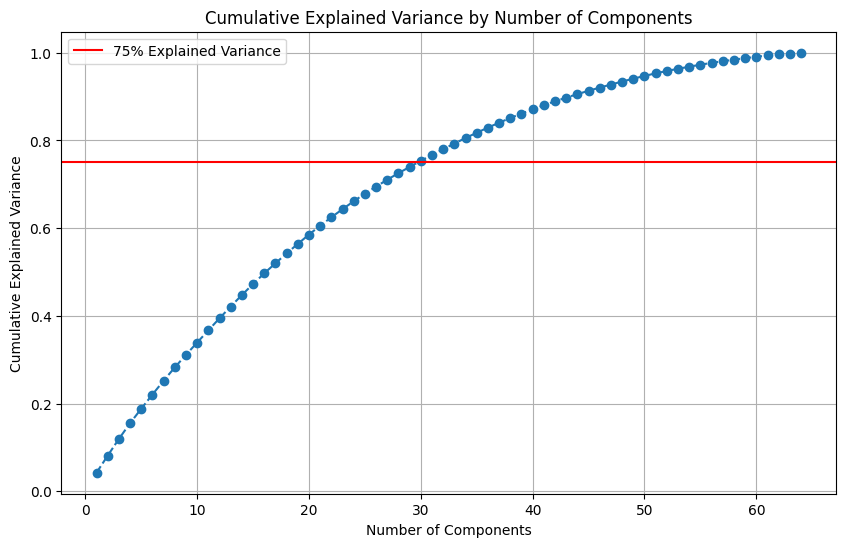

In [10]:
# 1. Run PCA without specifying n_components to get all components
pca_full = PCA()
pca_full.fit(embedding_matrix_normalized)

# 2. Calculate the cumulative explained variance
explained_variance_ratio_ = pca_full.explained_variance_ratio_.values
cumulative_variance = cp.cumsum(explained_variance_ratio_).get() # .get() moves data to numpy for plotting

# 3. Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.75, color='r', linestyle='-', label='75% Explained Variance')
plt.legend(loc='best')
plt.show()

The plot shows a classic "elbow" shape. The variance explained increases rapidly with the first few components and then flattens out. Choosing **30 components** captures roughly 75% of the original variance, which is an excellent trade-off between dimensionality reduction and information loss.

In [11]:
# Initialize PCA to reduce to 30 components
pca_30 = PCA(n_components=30)

# Fit PCA on the normalized embeddings and transform the data
embedding_pca_30 = pca_30.fit_transform(embedding_matrix_normalized)

print("Shape of the PCA-reduced embedding matrix:")
print(embedding_pca_30.shape)

Shape of the PCA-reduced embedding matrix:
(139, 30)


## **Step 5: Discovering Geopolitical Blocs with K-Means**

With our dimensionally-reduced embeddings, we can now use **cuML's K-Means** algorithm to cluster the countries and identify distinct geopolitical communities. Based on Cold War history, we might expect three primary groups: the Western Bloc (USA-aligned), the Eastern Bloc (USSR-aligned), and the Non-Aligned Movement.

### **Finding the Optimal Number of Clusters**

We'll use the **Silhouette Score** to programmatically find the best number of clusters (`k`). This score measures how similar an object is to its own cluster compared to other clusters. A higher score indicates better-defined clusters.

Silhouette score for 2 clusters: 0.0304
Silhouette score for 3 clusters: 0.0253
Silhouette score for 4 clusters: 0.0283
Silhouette score for 5 clusters: 0.0258
Silhouette score for 6 clusters: 0.0268
Silhouette score for 7 clusters: 0.0200
Silhouette score for 8 clusters: 0.0121
Silhouette score for 9 clusters: 0.0272
Silhouette score for 10 clusters: 0.0222

Best number of clusters is: 2 with a score of 0.0304


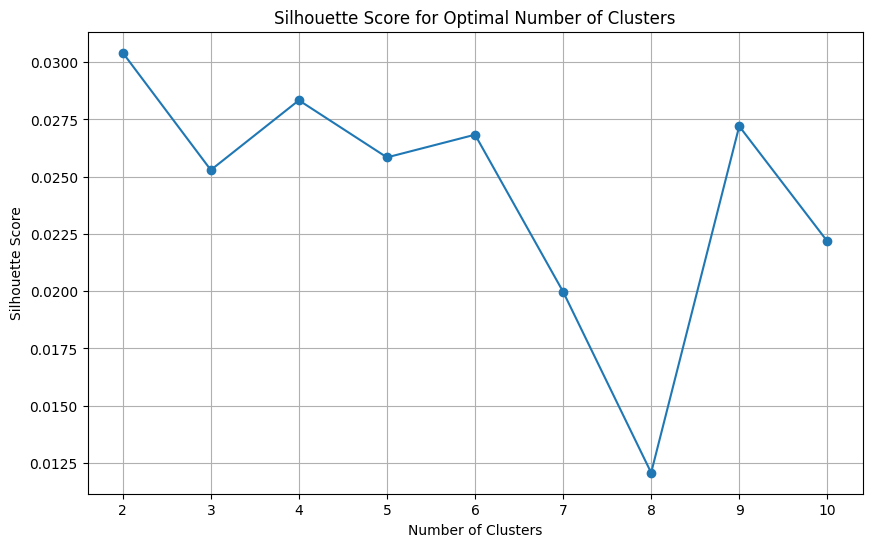

In [12]:
# --- Find the best number of clusters using the Silhouette Score ---
silhouette_scores = []
cluster_range = range(2, 11) # Test from 2 to 10 clusters

for n_clusters in cluster_range:
    # Initialize and fit K-Means on the GPU
    kmeans_gpu = KMeans(n_clusters=n_clusters, random_state=SEED)
    kmeans_gpu.fit(embedding_pca_30)

    # Calculate silhouette score
    score = silhouette_score(embedding_pca_30, kmeans_gpu.labels_)
    silhouette_scores.append(score)
    print(f"Silhouette score for {n_clusters} clusters: {score:.4f}")

# Find the best number of clusters
best_n_clusters = cluster_range[silhouette_scores.index(max(silhouette_scores))]
print(f"\nBest number of clusters is: {best_n_clusters} with a score of {max(silhouette_scores):.4f}")

# --- Plot the Silhouette Scores ---
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

The silhouette analysis suggests that **3 clusters** is an appropriate structure for this data, one more than our initial historical hypothesis of three. This is an interesting finding that we can investigate in the later steps.

## **Step 6: Visualization and Interpretation**

Now for the final payoff: visualizing our results. We'll bring the final, small datasets (the edge list and node cluster assignments) back to the CPU to visualize the network using NetworkX. Each node will be colored according to its assigned K-Means cluster.

/usr/local/lib/python3.12/dist-packages/cudf/core/reshape.py:397: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  warnings.warn(
/tmp/ipython-input-100057640.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab10')


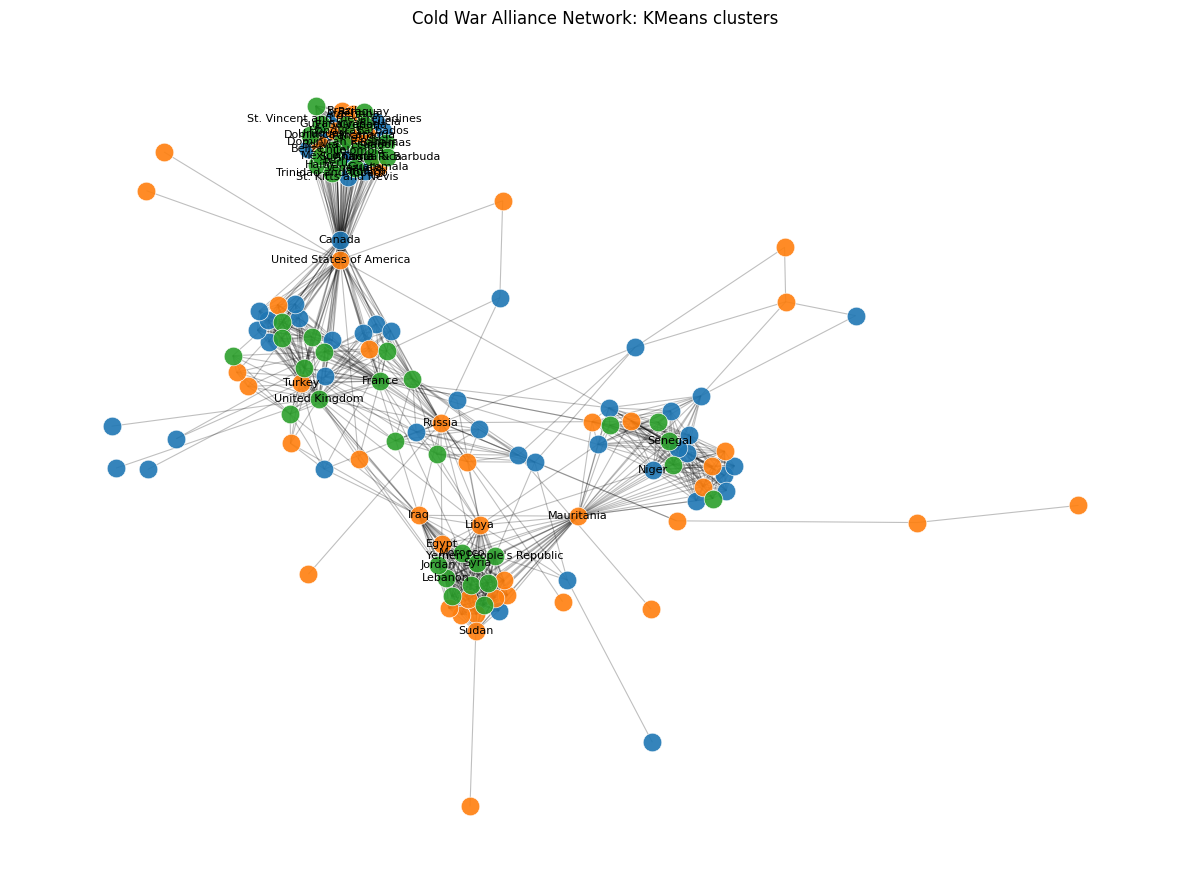

In [13]:
# ---------------------------
# PCA to 30 components (GPU)
# ---------------------------
# Keep explicit node ids so we can join labels later
_emb_df = embedding_matrix_normalized.reset_index()  # adds 'node_id' column from index
_feature_cols = [c for c in _emb_df.columns if c != 'node_id']

pca_30 = PCA(n_components=30)
emb_pca_30 = pca_30.fit_transform(_emb_df[_feature_cols])  # cuDF DataFrame (n_nodes, 30)
emb_pca_30 = cudf.DataFrame(emb_pca_30)
emb_pca_30['node_id'] = _emb_df['index']

# ---------------------------
# KMeans (GPU)
# ---------------------------
kmeans = KMeans(n_clusters=3, random_state=SEED)
kmeans.fit(emb_pca_30.drop(columns=['node_id']))

clusters_cudf = cudf.DataFrame({
    'node_id': emb_pca_30['node_id'],
    'cluster': kmeans.labels_
})

# -------------------------------------------
# Bring small, final tables to CPU for plotting
# -------------------------------------------
# Edge list for NetworkX
edges_pdf = int_edge_list.compute().to_pandas()[['source','target']].astype(int)
# Node labels & cluster assignments
nodes_pdf = node_map.to_pandas()
clusters_pdf = clusters_cudf.to_pandas()

# Merge node names with cluster labels
nodes_pdf = nodes_pdf.merge(clusters_pdf, on='node_id', how='left')

# ---------------------------
# Build NetworkX graph (CPU)
# ---------------------------
G_nx = nx.from_pandas_edgelist(edges_pdf, source='source', target='target', create_using=nx.Graph)

# Attach attributes: country name + cluster id
name_map = dict(zip(nodes_pdf['node_id'], nodes_pdf['node_name']))
cluster_map = dict(zip(nodes_pdf['node_id'], nodes_pdf['cluster']))

nx.set_node_attributes(G_nx, name_map, name='name')
nx.set_node_attributes(G_nx, cluster_map, name='cluster')

# ---------------------------
# Spring layout & plot
# ---------------------------
pos = nx.spring_layout(G_nx, seed=SEED, k=None)  # Fruchterman-Reingold force-directed

plt.figure(figsize=(12, 9))

# Choose a qualitative colormap and get 4 distinct colors
cmap = get_cmap('tab10')
cluster_colors = {i: cmap(i) for i in range(4)}

# Draw nodes cluster-by-cluster for crisp coloring
for c in range(4):
    nodes_in_c = [n for n, d in G_nx.nodes(data=True) if d.get('cluster') == c]
    nx.draw_networkx_nodes(
        G_nx,
        pos,
        nodelist=nodes_in_c,
        node_size=180,
        node_color=[cluster_colors[c]],
        alpha=0.9,
        linewidths=0.5,
        edgecolors='white'
    )

# Draw edges
nx.draw_networkx_edges(G_nx, pos, alpha=0.25, width=0.8)

# Optionally label a subset of nodes to reduce clutter (e.g., high degree)
deg = dict(G_nx.degree())
# Take top 20 by degree for labeling
top_nodes = sorted(deg, key=deg.get, reverse=True)[:50]
labels = {n: G_nx.nodes[n].get('name', str(n)) for n in top_nodes}

nx.draw_networkx_labels(G_nx, pos, labels=labels, font_size=8)

plt.title('Cold War Alliance Network: KMeans clusters')
plt.axis('off')
plt.tight_layout()
plt.show()


### **Finding Structurally Similar Nations**

Finally, we can use our embeddings to find countries that played analogous roles in the global alliance network, even if they weren't directly allied. We do this by calculating the **cosine similarity** between their embedding vectors on the GPU.

In [14]:
def find_most_similar_gpu(node_name, top_n=10):
    """Finds the most similar nodes using GPU-accelerated cosine similarity."""
    # Find the integer ID for the given country name
    node_id_series = node_map[node_map['node_name'] == node_name]['node_id']
    if node_id_series.empty:
        print(f"Node '{node_name}' not found.")
        return []
    node_id = node_id_series.iloc[0]

    # Get the embedding vector for that country
    node_embedding = embedding_matrix.iloc[node_id:node_id+1]

    # Calculate cosine distance (1 - cosine similarity) on the GPU
    distances = pairwise_distances(node_embedding, embedding_matrix, metric='cosine').iloc[0]

    # Get the top N closest nodes (smallest distance)
    top_indices = distances.nsmallest(top_n + 1).index.to_pandas().tolist()

    # Map indices back to names, excluding the node itself
    similar_nodes_df = node_map.iloc[top_indices].query(f"node_id != {node_id}")
    return similar_nodes_df['node_name'].to_pandas().tolist()

# --- Analysis ---
print("\nMost similar to 'United States of America':")
print(find_most_similar_gpu('United States of America'))

print("\nMost similar to 'Russia':")
print(find_most_similar_gpu('Russia'))


Most similar to 'United States of America':
['Belgium', 'St. Lucia', 'Turkey', 'Qatar', 'Malta', 'Iceland', 'Iran', 'Belize', 'Cuba', 'Spain']

Most similar to 'Russia':
['Uganda', 'Ivory Coast', 'Egypt', 'Bangladesh', 'Madagascar', 'Thailand', 'Iraq', 'North Korea', 'Democratic Republic of the Congo', 'Mexico']


This analysis reveals nations that are structurally similar based on their alliance patterns, for example, Russia and Iraq both serve as bridges across European and African countries.

-----

## **Conclusion**

In this tutorial, we showed an end-to-end, GPU-accelerated workflow for graph machine learning. By leveraging **Dask** for scalable data processing and the **RAPIDS** ecosystem (**cuDF**, **cuGraph**, and **cuML**), we were able to transform raw historical data to deep geopolitical insights with remarkable speed.

Our key findings include:

1.  **Quantitative Confirmation:** We quantitatively identified the major power blocs of the Cold War, confirming historical understanding of data-driven methods.
2.  **Discovery of Nuance:** Our analysis suggested an optimal structure of four clusters, pointing to a more complex geopolitical landscape than the simple East-West-Nonaligned trichotomy. Visual inspection suggests this fourth cluster may represent a distinct group of nations in Latin America or the Middle East.
3.  **Structural Equivalence:** We identified countries that played similar roles in the network, showcasing the power of embeddings to capture abstract structural properties.

This approach represents a modern, high-performance paradigm for tackling large-scale graph analytics, enabling researchers and analysts to explore complex networks faster and at scales that were previously intractable.